In [1]:
from scipy.misc import imread

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
from keras.models import Model
from keras.layers import *
from keras.layers import deserialize as layer_from_config
import numpy as np
# import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

/home/shaun/anaconda3/envs/py35/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
file = '../3_classes_closeup/Basal Cell carcinoma/000024H.JPG'

img = imread(file)

/home/shaun/anaconda3/envs/py35/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


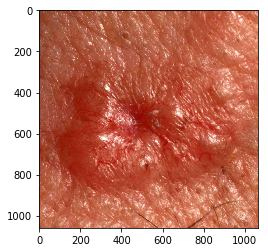

In [3]:
plt.imshow(img)

In [4]:
model = VGG16(weights='imagenet')

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
for layer in model.layers:
    print (type(layer))

<class 'keras.engine.topology.InputLayer'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.core.Flatten'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dense'>


In [7]:
def layer_type(layer):
    # TODO: use isinstance() instead.
    return str(layer)[10:].split(" ")[0].split(".")[-1]


def detect_configuration(model):
    # must return the configuration and the number of the first pooling layer

    # Names (types) of layers from end to beggining
    inverted_list_layers = [layer_type(layer) for layer in model.layers[::-1]]

    layer1 = None
    layer2 = None

    i = len(model.layers)

    for layer in inverted_list_layers:
        i -= 1
        if layer2 is None:
            if layer == "GlobalAveragePooling2D" or layer == "GlobalMaxPooling2D":
                layer2 = layer

            elif layer == "Flatten":
                return "local pooling - flatten", i - 1

        else:
            layer1 = layer
            break

    if layer1 == "MaxPooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (same type)", i
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (same type)", i

    elif layer1 == "MaxPooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (different type)", i + 1
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (different type)", i + 1

    else:
        return "global pooling", i + 1

In [8]:
detect_configuration(model)

('local pooling - flatten', 18)

In [9]:
model.layers[1]

In [73]:
img_input = Input(shape=(None, None, 3))

In [74]:
middle_model= Model(inputs = model.layers[1].input, outputs = model.layers[17].output)

In [75]:
x = middle_model(img_input)

In [76]:
model.layers[18]

In [77]:
layer = model.layers[18]

In [78]:
dic = layer.get_config()

In [79]:
dic

{'data_format': 'channels_last',
 'name': 'block5_pool',
 'padding': 'valid',
 'pool_size': (2, 2),
 'strides': (2, 2),
 'trainable': True}

In [80]:
atrous_rate = dic["strides"][0]
atrous_rate

2

In [81]:
dic["strides"] = (1, 1)

In [82]:
def from_config(layer, config_dic):
    config_correct = {}
    config_correct['class_name'] = str(type(layer))
    config_correct['config'] = config_dic
    return layer_from_config(config_correct, custom_objects={str(type(layer)): layer})

In [83]:
newpool = from_config(layer, dic)

In [84]:
newpool.get_config()

{'data_format': 'channels_last',
 'name': 'block5_pool',
 'padding': 'valid',
 'pool_size': (2, 2),
 'strides': (1, 1),
 'trainable': True}

In [85]:
x = newpool(x)

In [86]:
def get_dim(model, layer_index, input_shape=None):
    # Input shape is the shape of images used during training.
    if input_shape is not None:
        dummy_vector = np.zeros((1,) + input_shape)
    else:
        if model.layers[0].input_shape[2] is None:
            raise ValueError(
                'You must provide \"input_shape = (3,256,256)\" for example when calling the function.')
        dummy_vector = np.zeros((1,) + model.layers[0].input_shape[1:])

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.layers[layer_index].output)

    out = intermediate_layer_model.predict(dummy_vector)

    return out.shape

In [87]:
input_shape = None # (224, 224, 3)

In [88]:
size = get_dim(model, 18, input_shape)[2]

In [89]:
size

7

In [90]:
def add_reshaped_layer(layer, x, size, no_activation=False, atrous_rate=None):
    conf = layer.get_config()

    if no_activation:
        activation = "linear"
    else:
        activation = conf["activation"]

    if size == 1:
        new_layer = Conv2D(conf["units"], (size, size),
                           activation=activation, name=conf['name'])
    else:
        new_layer = Conv2D(conf["units"], (size, size),
                           dilation_rate=(atrous_rate, atrous_rate),
                           activation=activation, padding='valid',
                           name=conf['name'])

    x = new_layer(x)
    # We transfer the weights:
    insert_weights(layer, new_layer)
    return x

In [91]:
len(model.layers)

23

In [92]:
model.layers[20]

In [93]:
model.layers[19]

In [94]:
model.layers[20].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc1',
 'trainable': True,
 'units': 4096,
 'use_bias': True}

In [95]:
def insert_weights(layer, new_layer):
    W, b = layer.get_weights()
    ax1, ax2, previous_filter, n_filter = new_layer.get_weights()[0].shape
    new_W = W.reshape((ax1, ax2, previous_filter, n_filter))
    new_W = new_W.transpose((0, 1, 2, 3))

    new_layer.set_weights([new_W, b])

In [96]:
x = add_reshaped_layer(model.layers[20], x, size, atrous_rate=atrous_rate)

In [97]:
def copy_last_layers(model, begin, x, last_activation='linear'):
    i = begin

    for layer in model.layers[begin:]:
        if layer_type(layer) == "Dense":
            last_activation = layer.get_config()["activation"]
            if i == len(model.layers) - 1:
#                 print ('Last Layer, {}'.format(type(x)))
                x = add_reshaped_layer(layer, x, 1, no_activation=True)
            else:
#                 print ('Layer {}'.format(type(x)))
                x = add_reshaped_layer(layer, x, 1)

        elif layer_type(layer) == "Dropout" or layer_type(layer) == 'Reshape':
            pass

        elif layer_type(layer) == "Activation" and i == len(model.layers) - 1:
            last_activation = layer.get_config()['activation']
            break
        else:
            x = add_to_model(x, layer)
        i += 1
    if last_activation == 'softmax':
        x = Softmax4D(name="softmax")(x)
    elif last_activation in ['sigmoid', 'linear']:
        x = Activation('sigmoid')(x)
    else:
        raise TypeError('activation ' + str(last_activation) + " Not supported.")
    print("last activation:", last_activation)
    return x

In [98]:
last_activation = model.layers[20].get_config()["activation"]
last_activation

'relu'

In [99]:
for layer in model.layers[21:]:
    print (type(layer), layer.get_config()['activation'])

(<class 'keras.layers.core.Dense'>, 'relu')
(<class 'keras.layers.core.Dense'>, 'softmax')


In [100]:
ch_axis = 3

In [101]:
class Softmax4D(Layer):
    def __init__(self, axis=None, **kwargs):
        if axis is None:
            axis = ch_axis
        self.axis = axis
        super(Softmax4D, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def compute_output_shape(self, input_shape):
        return input_shape

In [102]:
x = copy_last_layers(model, 21, x, last_activation=last_activation)

('last activation:', 'softmax')


In [103]:
myModel = Model(img_input, x)

In [104]:
myModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
model_8 (Model)              multiple                  14714688  
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, None, None, 512)   0         
_________________________________________________________________
fc1 (Conv2D)                 (None, None, None, 4096)  102764544 
_________________________________________________________________
fc2 (Conv2D)                 (None, None, None, 4096)  16781312  
_________________________________________________________________
predictions (Conv2D)         (None, None, None, 1000)  4097000   
_________________________________________________________________
softmax (Softmax4D)          (None, None, None, 1000)  0         
Total para

In [149]:
img = image.load_img('dog.jpg', target_size=(500, 500))

In [150]:
img.size

(500, 500)

In [151]:
f = image.img_to_array(img)
f = np.expand_dims(f, axis=0)

In [152]:
f.shape

(1, 500, 500, 3)

In [153]:
output = myModel.predict(f)

In [154]:
output.shape

(1, 18, 18, 1000)

In [155]:
output = output[0]

In [156]:
output.ndim

3

In [158]:
temp = output[:, :, :]

In [159]:
heatmap = np.sum(temp, axis = 2)

In [160]:
heatmap.shape

(18, 18)

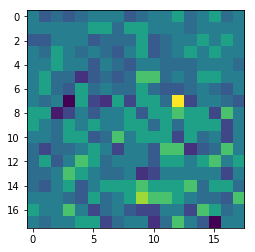

In [161]:
plt.imshow(heatmap)

In [166]:
mims = np.min(temp, axis = 2)

In [167]:
mims.shape

(18, 18)

In [168]:
mims

array([[6.71155476e-06, 7.08687548e-06, 8.05730269e-06, 1.01040096e-05,
        9.45134980e-06, 6.97339647e-06, 4.31821172e-06, 5.57286921e-06,
        4.24721838e-06, 5.33934372e-06, 3.53913310e-06, 4.41588509e-06,
        3.41258169e-06, 2.92835171e-06, 3.71755232e-06, 6.75144520e-06,
        8.30345653e-06, 5.62822652e-06],
       [8.99201132e-06, 5.74068099e-06, 3.93538403e-06, 4.17751289e-06,
        2.05665924e-06, 1.02047863e-06, 4.40768559e-07, 4.33091543e-07,
        2.35713586e-07, 4.91355706e-07, 4.68107231e-07, 8.62763727e-07,
        8.82532163e-07, 1.98382986e-06, 1.79124027e-06, 4.98722011e-06,
        6.18844979e-06, 6.13834391e-06],
       [6.00848216e-06, 2.87389798e-06, 7.26692463e-07, 8.92894093e-07,
        1.95218362e-07, 1.62105692e-07, 4.04924272e-08, 6.42521201e-08,
        3.46937945e-08, 8.81761366e-08, 5.83690287e-08, 1.78967426e-07,
        7.12185582e-08, 2.47724302e-07, 2.16166399e-07, 1.07927531e-06,
        1.24148460e-06, 3.47360037e-06],
       [6.020

In [169]:
maxs = np.max(temp, axis = 2)

In [170]:
maxs.shape

(18, 18)

In [171]:
maxs

array([[0.02422429, 0.01957579, 0.01910111, 0.01930141, 0.02807979,
        0.04552709, 0.06456123, 0.05648314, 0.06413335, 0.03658035,
        0.04450309, 0.04466069, 0.07228323, 0.07641885, 0.09844867,
        0.06112374, 0.05632521, 0.07513623],
       [0.0329155 , 0.0551013 , 0.06770287, 0.0770899 , 0.09015123,
        0.14654483, 0.1613593 , 0.19951333, 0.19002922, 0.18729739,
        0.16563661, 0.14162773, 0.1310573 , 0.14617437, 0.1252007 ,
        0.06055465, 0.04947358, 0.05613716],
       [0.03813714, 0.05303429, 0.06797985, 0.08927499, 0.11533649,
        0.0995013 , 0.13907674, 0.15874372, 0.16711651, 0.16138202,
        0.19362056, 0.16171925, 0.19200648, 0.24410173, 0.16997837,
        0.11811315, 0.15768   , 0.07896019],
       [0.04783723, 0.08228754, 0.12441809, 0.15942757, 0.21596612,
        0.19343127, 0.18319891, 0.1916064 , 0.1939434 , 0.24177456,
        0.24035762, 0.26897794, 0.3277619 , 0.29605433, 0.20477098,
        0.10273022, 0.13812552, 0.12177921],
    

In [162]:
heatmap2 = np.max(temp, axis = 2)

In [163]:
heatmap2.shape

(18, 18)

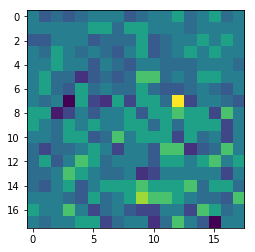

In [164]:
plt.imshow(heatmap)

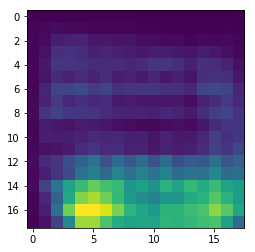

In [199]:
plt.imshow(temp[...,250])